# Heart Sound Dataset EDA
Goal: Understand label balance, durations, sample rates, basic signal + spectral characteristics, and identify anomalies

In [9]:
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import soundfile as sf
import librosa as lr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

DATA_ROOT = Path("../data").resolve()
META_FILES = ["set_a.csv", "set_b.csv"]
ACCEPT_LABELS = {"normal", "murmur", "artifact"}  # ignore unlabeled / test noise
RANDOM_SEED = 42
MAX_PROBE = None   # set small int to limit rows during fast debugging

DATA_ROOT

WindowsPath('C:/Users/Michi/heatbeat-sounds/data')

In [10]:
# --- 1. Load raw metadata (no mutation beyond adding source marker) ---
def read_metadata_frames(root: Path, meta_files: list[str]) -> pd.DataFrame:
    frames = []
    for mf in meta_files:
        df = pd.read_csv(root / mf)
        df["__meta_source"] = mf
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# --- 2. Clean + attach absolute paths (pure transformation) ---
def prepare_metadata(df: pd.DataFrame,
                     root: Path,
                     accept_labels: set[str] | None = None,
                     path_col: str = "path_fname") -> pd.DataFrame:
    out = df.copy()
    if "label" in out.columns:
        out["label"] = out["label"].astype(str).str.lower().str.strip()
        if accept_labels:
            out = out[out["label"].isin(accept_labels)]
    out[path_col] = out["fname"].map(lambda x: root / x)
    return out.reset_index(drop=True)

# --- 3. Optional: add existence + (optional) drop missing ---
def add_existence_flag(df: pd.DataFrame,
                       path_col: str = "path_fname",
                       drop_missing: bool = True) -> pd.DataFrame:
    out = df.copy()
    out["exists"] = out[path_col].map(lambda p: p.is_file())
    if drop_missing:
        missing = (~out["exists"]).sum()
        if missing:
            print(f"Dropping {missing} rows with missing audio.")
        out = out[out["exists"]].copy()
        out = out.drop(columns=["exists"])
    return out.reset_index(drop=True)

# --- (Optional) 4. Probe durations/sample rates (keep separate: expensive I/O) ---
def probe_durations(df: pd.DataFrame,
                    path_col: str = "path_fname",
                    max_files: int | None = None) -> pd.DataFrame:
    out = df.copy()
    paths = out[path_col]
    if max_files:
        paths = paths.iloc[:max_files]
    durations = []
    srs = []
    for p in paths:
        try:
            with sf.SoundFile(p) as f:
                sr = f.samplerate
                dur = len(f) / sr
        except Exception:
            sr = np.nan; dur = np.nan
        durations.append(dur); srs.append(sr)
    out.loc[paths.index, "duration_sec"] = durations
    out.loc[paths.index, "sr"] = srs
    return out

In [11]:
raw = read_metadata_frames(DATA_ROOT, META_FILES)
meta = prepare_metadata(raw, DATA_ROOT, ACCEPT_LABELS)
meta = add_existence_flag(meta, drop_missing=True)
meta = probe_durations(meta, max_files=None)
meta.head()

Dropping 415 rows with missing audio.


,dataset,fname,label,sublabel,__meta_source,path_fname,duration_sec,sr
0,a,set_a/artifact__201012172012.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
1,a,set_a/artifact__201105040918.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
2,a,set_a/artifact__201105041959.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
3,a,set_a/artifact__201105051017.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0
4,a,set_a/artifact__201105060108.wav,artifact,NaN,set_a.csv,C:\Users\Michi\heatbeat-sounds\data\set_a\arti...,9.0,44100.0


In [12]:
label_counts = meta["label"].value_counts().rename("count")
label_pct = (label_counts / label_counts.sum() * 100).round(2).rename("percent")
display(pd.concat([label_counts, label_pct], axis=1))

,count,percent
label,,
artifact,40,38.10
murmur,34,32.38
normal,31,29.52


C:\Users\Michi\AppData\Local\Temp\ipykernel_36868\1756429903.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


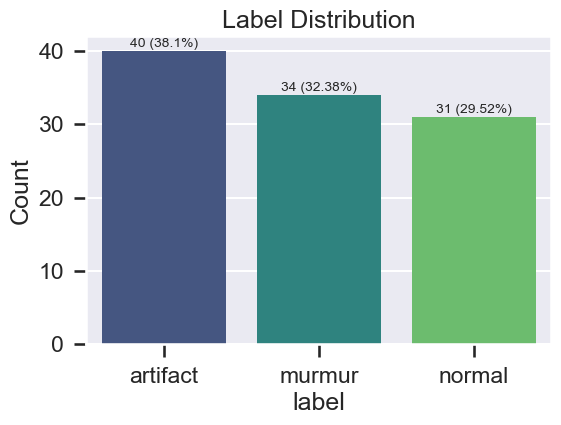

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label Distribution")
plt.ylabel("Count")
for i,(lab,val) in enumerate(label_counts.items()):
    plt.text(i, val + 0.5, f"{val} ({label_pct[lab]}%)", ha="center", fontsize=10)
plt.show()

In [14]:
missing_cols = meta.isna().sum()
print("Missing per column:")
display(missing_cols[missing_cols > 0])
print("Any duplicated fname?", meta["fname"].duplicated().any())

Missing per column:


sublabel    105
dtype: int64

Any duplicated fname? False


count    105.000000
mean       8.220761
std        1.242029
min        0.936372
25%        7.935556
50%        8.884059
75%        9.000000
max        9.000000
Name: duration_sec, dtype: float64


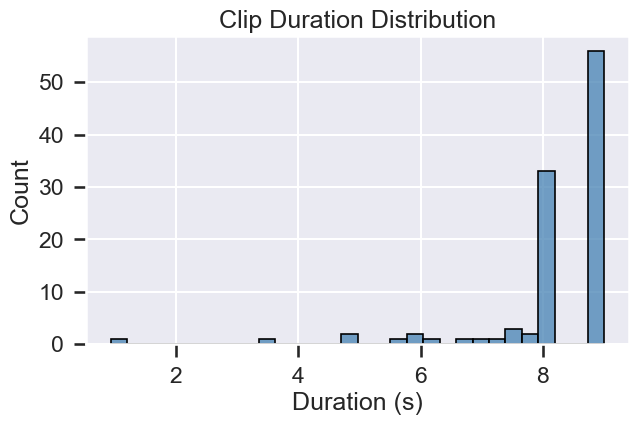

In [15]:
print(meta["duration_sec"].describe())
plt.figure(figsize=(7,4))
sns.histplot(meta["duration_sec"], bins=30, color="steelblue")
plt.xlabel("Duration (s)")
plt.title("Clip Duration Distribution")
plt.show()

Sample rate counts:


sr
44100.0    105
Name: count, dtype: int64

C:\Users\Michi\AppData\Local\Temp\ipykernel_36868\837746181.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sr", data=meta, palette="magma")


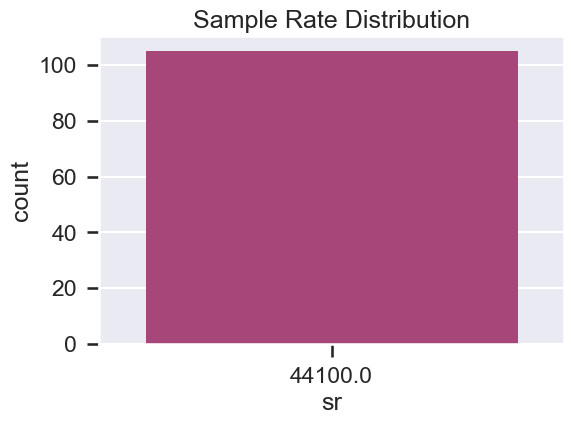

In [16]:
print("Sample rate counts:")
display(meta["sr"].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x="sr", data=meta, palette="magma")
plt.title("Sample Rate Distribution")
plt.show()

In [20]:
def basic_signal_stats(df, max_files=120):
    rows = []
    subset = df.sample(min(max_files, len(df)), random_state=RANDOM_SEED)
    for _, r in subset.iterrows():
        try:
            y, sr = sf.read(r.path_fname)
            if y.ndim > 1:
                y = y.mean(axis=1)
            rms = float(np.sqrt(np.mean(y**2)))
            peak = float(np.max(np.abs(y)))
            rows.append({"label": r.label, "rms": rms, "peak": peak})
        except Exception:
            continue
    return pd.DataFrame(rows)

sig_stats = basic_signal_stats(meta, max_files=meta.shape[0])
print(meta.shape[0], "files processed for signal stats.")
sig_stats.head()

105 files processed for signal stats.


,label,rms,peak
0,artifact,0.001457,0.057037
1,murmur,0.048801,0.332855
2,murmur,0.177454,0.999969
3,murmur,0.105243,0.592194
4,murmur,0.042091,0.519043


C:\Users\Michi\AppData\Local\Temp\ipykernel_36868\1114560493.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sig_stats, x="label", y="rms", palette="coolwarm", ax=ax[0])
C:\Users\Michi\AppData\Local\Temp\ipykernel_36868\1114560493.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sig_stats, x="label", y="peak", palette="coolwarm", ax=ax[1])


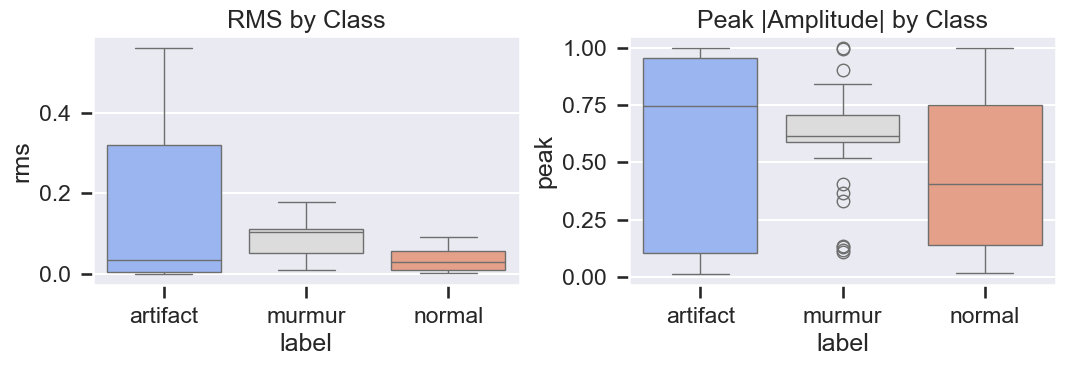

In [21]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.boxplot(data=sig_stats, x="label", y="rms", palette="coolwarm", ax=ax[0])
ax[0].set_title("RMS by Class")
sns.boxplot(data=sig_stats, x="label", y="peak", palette="coolwarm", ax=ax[1])
ax[1].set_title("Peak |Amplitude| by Class")
plt.tight_layout()
plt.show()

In [22]:
def spectral_summary(df, max_files=70):
    rows = []
    subset = df.sample(min(max_files, len(df)), random_state=RANDOM_SEED)
    for _, r in subset.iterrows():
        try:
            y, sr = lr.load(r.path_fname, sr=None, mono=True)
            S = np.abs(lr.stft(y, n_fft=1024, hop_length=256))
            centroid = lr.feature.spectral_centroid(S=S, sr=sr).mean()
            bandwidth = lr.feature.spectral_bandwidth(S=S, sr=sr).mean()
            rolloff = lr.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.90).mean()
            zcr = lr.feature.zero_crossing_rate(y).mean()
            rows.append({
                "label": r.label,
                "centroid": centroid,
                "bandwidth": bandwidth,
                "rolloff": rolloff,
                "zcr": zcr
            })
        except Exception:
            continue
    return pd.DataFrame(rows)

spec_df = spectral_summary(meta, max_files=meta.shape[0])
spec_df.head()

,label,centroid,bandwidth,rolloff,zcr
0,artifact,5360.204722,5912.013720,15557.357463,0.157322
1,murmur,1182.573252,3970.283692,2654.722836,0.008580
2,murmur,707.198816,2641.752343,1048.673288,0.007166
3,murmur,754.899452,3089.147180,802.584036,0.005425
4,murmur,1484.966906,3508.231467,3491.572096,0.022197


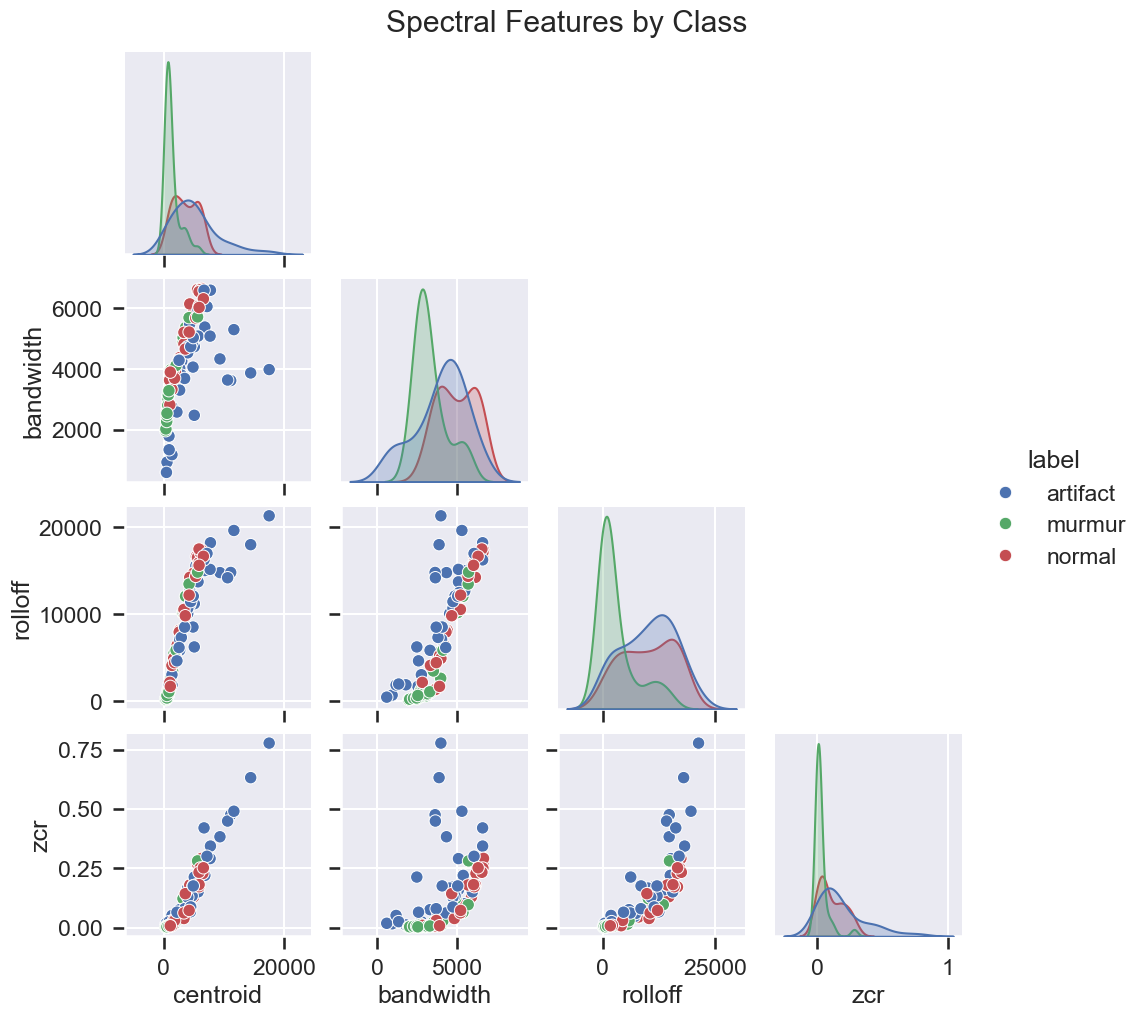

In [23]:
if not spec_df.empty:
    sns.pairplot(spec_df, hue="label",
                 vars=["centroid","bandwidth","rolloff","zcr"],
                 diag_kind="kde", corner=True)
    plt.suptitle("Spectral Features by Class", y=1.02)
    plt.show()

In [24]:
examples = {}
for lab in sorted(meta["label"].unique()):
    row = meta[meta["label"] == lab].head(1)
    if len(row):
        examples[lab] = row.iloc[0].path_fname
examples

{'artifact': WindowsPath('C:/Users/Michi/heatbeat-sounds/data/set_a/artifact__201012172012.wav'),
 'murmur': WindowsPath('C:/Users/Michi/heatbeat-sounds/data/set_a/murmur__201101051104.wav'),
 'normal': WindowsPath('C:/Users/Michi/heatbeat-sounds/data/set_a/normal__201101070538.wav')}

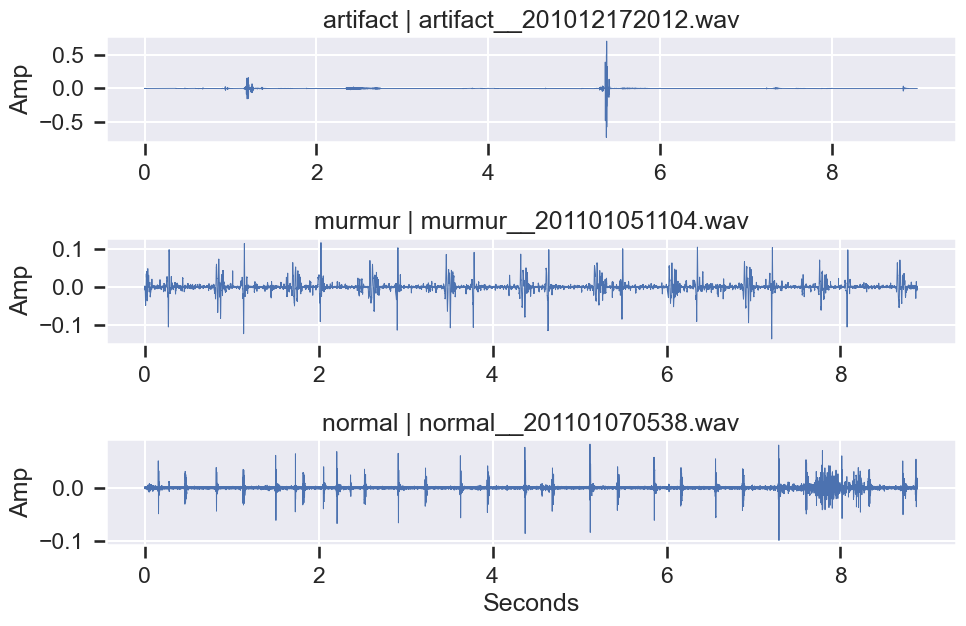

In [25]:
fig, axes = plt.subplots(len(examples), 1, figsize=(10, 2.2*len(examples)))
if len(examples) == 1:
    axes = [axes]
for ax, (lab, path) in zip(axes, examples.items()):
    y, sr = lr.load(path, sr=None, mono=True)
    t = np.arange(len(y))/sr
    ax.plot(t, y, lw=0.7)
    ax.set_title(f"{lab} | {path.name}")
    ax.set_ylabel("Amp")
axes[-1].set_xlabel("Seconds")
plt.tight_layout()
plt.show()

C:\Users\Michi\AppData\Local\Temp\ipykernel_36868\2613206647.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


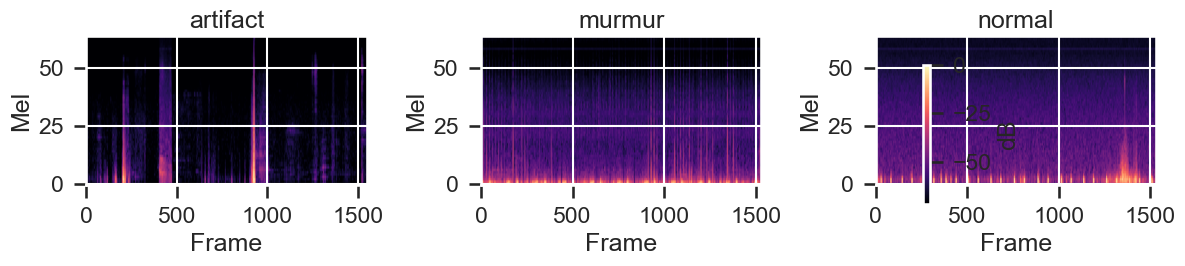

In [27]:
fig, axes = plt.subplots(1, len(examples), figsize=(4*len(examples), 3))
if len(examples) == 1:
    axes = [axes]
for ax, (lab, path) in zip(axes, examples.items()):
    y, sr = lr.load(path, sr=None, mono=True)
    M = lr.feature.melspectrogram(y=y, sr=sr, n_mels=64, hop_length=256)
    Mdb = lr.power_to_db(M, ref=np.max)
    im = ax.imshow(Mdb, origin="lower", aspect="auto", cmap="magma")
    ax.set_title(lab)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mel")
fig.colorbar(im, ax=axes, shrink=0.6, label="dB")
plt.tight_layout()
plt.show()

In [29]:
out_path = DATA_ROOT / "heartbeat_metadata_enriched.csv"
meta.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: C:\Users\Michi\heatbeat-sounds\data\heartbeat_metadata_enriched.csv
